
# Clusterização com Visualização Avançada

Este notebook explora técnicas de **clusterização em larga escala** com ênfase na influência das **métricas de distância** e **visualização dos agrupamentos** usando **PCA**, **t-SNE** e **UMAP**.

---

## Etapas da Aula:
1. Carregamento e expansão do dataset
2. Aplicação de MiniBatchKMeans com múltiplas métricas
3. Clusterização com DBSCAN e Agglomerative Clustering
4. Visualização com PCA, t-SNE e UMAP
5. Análise dos resultados



## Métricas de Distância em Clusterização

A clusterização depende diretamente da definição de **semelhança ou distância** entre os pontos. Diferentes métricas podem levar a resultados drasticamente distintos.

### 🔹 Distância Euclidiana

A distância euclidiana é a forma mais comum de medir a separação entre dois pontos em um espaço contínuo:

$$
d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}
$$

Essa métrica é adequada quando os dados estão bem normalizados e possuem uma estrutura esférica.

---

### 🔹 Distância Manhattan (Cityblock)

A distância Manhattan mede o somatório das diferenças absolutas entre as coordenadas:

$$
d(p, q) = \sum_{i=1}^{n} |p_i - q_i|
$$

É mais robusta a **outliers** e útil quando os dados têm distribuições com “caminhos retilíneos”.

---

### 🔹 Distância Cosseno

A distância cosseno mede o ângulo entre dois vetores, sendo útil em **espaços de alta dimensionalidade**:

$$
d(p, q) = 1 - \frac{p \cdot q}{\|p\| \|q\|}
$$

Essa métrica é especialmente útil quando o que importa é a **direção** e não o módulo dos vetores, como em dados textuais ou embeddings.



## Avaliação da Qualidade com Silhouette Score

O **Silhouette Score** é uma métrica que quantifica a **coerência dos clusters** gerados, variando entre -1 e 1.

Para cada ponto:

- \( a \): distância média para os pontos no mesmo cluster
- \( b \): menor distância média para pontos de outro cluster (vizinho mais próximo)

O Silhouette é calculado por:

$$
s = \frac{b - a}{\max(a, b)}
$$

- **s próximo de 1**: ponto bem ajustado ao seu cluster
- **s próximo de 0**: ponto na fronteira entre clusters
- **s negativo**: ponto provavelmente mal alocado

### Uso Prático:
- Ajuda a validar o **número ideal de clusters**
- Útil para comparar a eficácia entre diferentes algoritmos ou métricas



## Etapa 1: Preparação dos Dados

Usamos o dataset **Digits** do `sklearn`, contendo imagens de dígitos escritos à mão (8x8 pixels), com 64 features por instância.

Como o dataset original possui apenas 1797 instâncias, utilizamos **reamostragem com reposição** para gerar **80.000 amostras**, simulando um cenário realista de **larga escala**.

Os dados são padronizados com `StandardScaler` para garantir que cada feature tenha média 0 e desvio padrão 1, o que é essencial para métricas baseadas em distância.


In [ ]:

from sklearn.datasets import load_digits
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Carregar e replicar Digits
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Expandir para 80.000 instâncias
X_large, y_large = resample(X_digits, y_digits, n_samples=80000, replace=True, random_state=42)

# Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_large)

print(f"Dimensão dos dados replicados: {X_scaled.shape}")


Dimensão dos dados replicados: (80000, 64)



## Etapa 2: MiniBatchKMeans com Múltiplas Métricas

### ✅ O que é MiniBatchKMeans?

MiniBatchKMeans é uma **variação eficiente do KMeans**, projetada para grandes volumes de dados. Em vez de usar todas as amostras a cada iteração, ele utiliza pequenos lotes (*mini-batches*) para atualizar os centróides dos clusters.

### 🎯 Por que usar aqui?

- Estamos lidando com **80.000 amostras**.
- MiniBatchKMeans mantém boa qualidade de agrupamento com menor custo computacional.

### 🧮 Métricas utilizadas:

- **Euclidiana**: padrão para dados contínuos e normalizados.
- **Manhattan**: útil quando há outliers ou caminhos em grade.
- **Cosseno**: ideal para dados com direção relevante, como texto ou embeddings.

### 📏 Avaliação com Silhouette Score

Para evitar alto custo computacional, o Silhouette Score é calculado em um subconjunto de 5.000 pontos.



## Etapa 2: MiniBatchKMeans com Múltiplas Métricas

O `MiniBatchKMeans` é uma versão eficiente do KMeans tradicional, ideal para grandes volumes de dados.

Avaliamos o desempenho com 3 métricas:
- **Euclidiana**
- **Manhattan**
- **Cosseno**

Como o cálculo do `Silhouette Score` com matriz de distância completa pode ser custoso, usamos um subconjunto de 5.000 amostras para essa análise.


In [ ]:

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

metrics = ["euclidean", "manhattan", "cosine"]

print("MiniBatchKMeans em Subset de 5000 amostras\n")
for metric in metrics:
    print(f"\nMétrica: {metric}")
    X_subset = X_scaled[:5000]
    dist_matrix = pairwise_distances(X_subset, metric=metric)

    kmeans = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=2048)
    labels = kmeans.fit_predict(X_subset)

    score = silhouette_score(dist_matrix, labels, metric="precomputed")
    print(f"MiniBatchKMeans com métrica {metric}: Silhouette Score = {score:.3f}")


MiniBatchKMeans em Subset de 5000 amostras


Métrica: euclidean
MiniBatchKMeans com métrica euclidean: Silhouette Score = 0.121

Métrica: manhattan
MiniBatchKMeans com métrica manhattan: Silhouette Score = 0.156

Métrica: cosine
MiniBatchKMeans com métrica cosine: Silhouette Score = 0.222



## Etapa 3: DBSCAN e Agglomerative Clustering

### ✅ DBSCAN

- Agrupa pontos com base em **densidade**.
- Detecta **outliers automaticamente**.
- Não precisa de número de clusters como parâmetro.

**Parâmetros principais:**
- `eps`: raio de vizinhança.
- `min_samples`: número mínimo de vizinhos próximos.

### ✅ Agglomerative Clustering

- Técnica **hierárquica bottom-up**.
- Agrupa pares de pontos ou clusters mais próximos até formar a hierarquia completa.
- Permite controle do número de clusters ao final.

⚠️ Ambos aplicados sobre subconjunto de **2.000 amostras** devido ao alto custo computacional.



## Etapa 3: DBSCAN e Agglomerative Clustering

Aplicamos agora dois algoritmos que não exigem pré-definição do número de clusters:

- **DBSCAN**: Detecta clusters de forma arbitrária e lida bem com outliers.
- **Agglomerative Clustering**: Uma técnica hierárquica que agrupa iterativamente os pontos mais próximos.

Para manter o desempenho, limitamos esta etapa a **2.000 amostras**.


In [ ]:

from sklearn.cluster import DBSCAN, AgglomerativeClustering

X_small = X_scaled[:2000]  # limitar tamanho por custo computacional
print("\nDBSCAN e Agglomerative Clustering em 2.000 amostras\n")

# DBSCAN
dbscan = DBSCAN(eps=1.3, min_samples=5, metric="euclidean")
db_labels = dbscan.fit_predict(X_small)
print(f"DBSCAN clusters: {len(set(db_labels)) - (1 if -1 in db_labels else 0)}")

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=10, metric="euclidean", linkage="ward")
agglo_labels = agglo.fit_predict(X_small)
print(f"Agglomerative Clustering clusters: {len(set(agglo_labels))}")



DBSCAN e Agglomerative Clustering em 2.000 amostras

DBSCAN clusters: 10
Agglomerative Clustering clusters: 10



## Etapa 4: Visualização com PCA

**PCA** (Principal Component Analysis) é uma técnica de redução de dimensionalidade linear que:
- Projeta os dados em um novo espaço de 2D preservando a **maior variância possível**.
- Ajuda a visualizar a separação entre clusters.



## Etapa 4: Visualização com PCA

`PCA` (Análise de Componentes Principais) reduz a dimensionalidade dos dados projetando-os em um novo espaço de 2 dimensões que preserva a maior variância possível.

Isso facilita a visualização da separação dos clusters gerados.


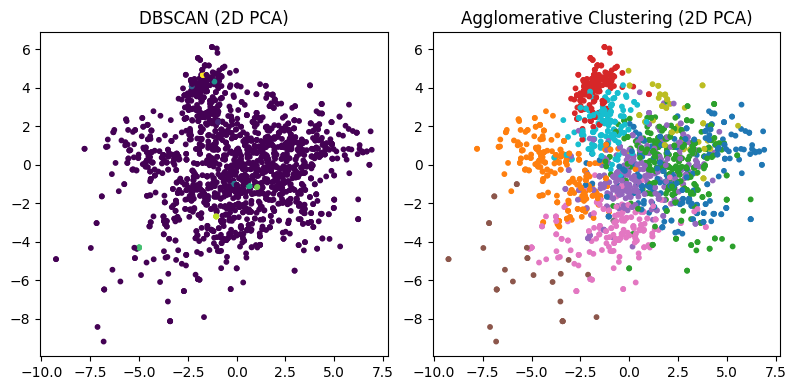

In [ ]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Redução de dimensionalidade
X_pca = PCA(n_components=2).fit_transform(X_small)

# Visualização DBSCAN
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, cmap='viridis', s=10)
plt.title("DBSCAN (2D PCA)")

# Visualização Agglomerative
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='tab10', s=10)
plt.title("Agglomerative Clustering (2D PCA)")
plt.tight_layout()
plt.show()



## Etapa 5: Visualização com t-SNE

`t-SNE` é uma técnica não linear para projetar dados em 2D, otimizando a preservação de **relações de vizinhança** locais.

**Parâmetros importantes:**
- `perplexity`: número de vizinhos a considerar.
- `n_iter`: número de iterações para convergência.

🔍 Ideal para explorar **subgrupos ocultos** em dados de alta dimensionalidade.



## Etapa 5: Visualização com t-SNE

`t-SNE` é uma técnica de redução de dimensionalidade não-linear que enfatiza a preservação da **estrutura local** dos dados, sendo muito utilizada para visualização de agrupamentos em espaços de alta dimensão.

Parâmetros importantes:
- `perplexity`: controla o número de vizinhos considerados
- `n_iter`: número de iterações da otimização


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


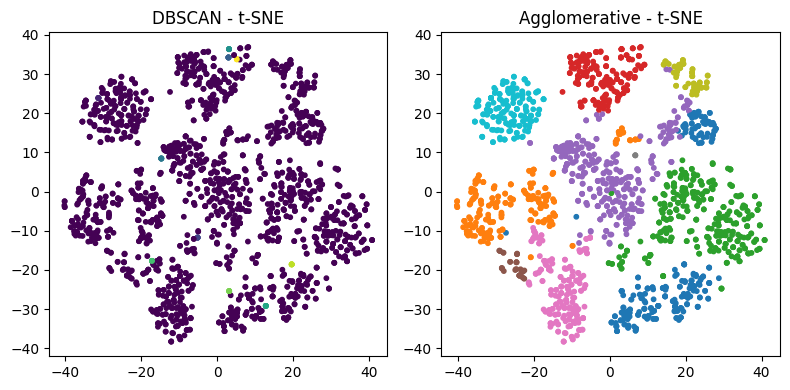

In [ ]:

from sklearn.manifold import TSNE

# t-SNE com 2 componentes
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500).fit_transform(X_small)

# Visualização t-SNE
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=db_labels, cmap='viridis', s=10)
plt.title("DBSCAN - t-SNE")

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=agglo_labels, cmap='tab10', s=10)
plt.title("Agglomerative - t-SNE")
plt.tight_layout()
plt.show()



## Etapa 6: Visualização com UMAP

`UMAP` (Uniform Manifold Approximation and Projection) é uma técnica moderna de redução de dimensionalidade com foco em preservar:
- **Estrutura local e global** dos dados.
- É mais rápida e estável que o t-SNE.

**Parâmetros principais:**
- `n_neighbors`: número de vizinhos próximos considerados.
- `min_dist`: controla a compactação dos pontos no espaço projetado.

🔍 Útil para grandes volumes de dados e resultados reprodutíveis.



## Etapa 6: Visualização com UMAP

`UMAP` (Uniform Manifold Approximation and Projection) é uma técnica mais recente e eficiente que o t-SNE, com vantagens como:

- Preservação da estrutura global e local
- Melhor escalabilidade
- Visualizações mais estáveis

É muito usado em aplicações modernas de visualização de embeddings.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


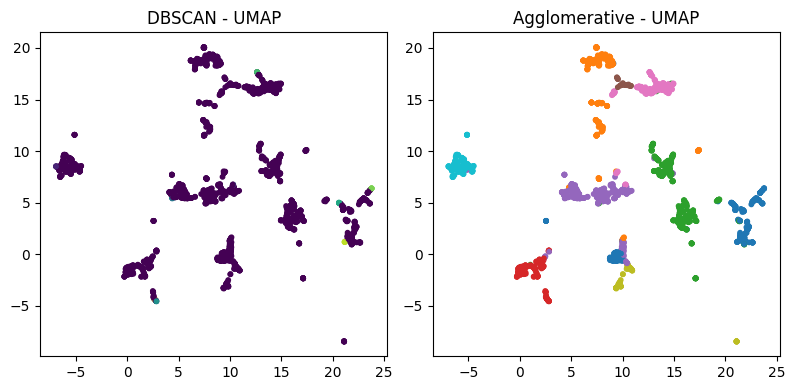

In [ ]:

import umap

# UMAP com 2 componentes
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_small)

# Visualização UMAP
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=db_labels, cmap='viridis', s=10)
plt.title("DBSCAN - UMAP")

plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=agglo_labels, cmap='tab10', s=10)
plt.title("Agglomerative - UMAP")
plt.tight_layout()
plt.show()



## Conclusões Finais

- A clusterização em grandes bases de dados requer algoritmos escaláveis, como MiniBatchKMeans
- A escolha da métrica de distância **impacta fortemente** os agrupamentos formados
- Visualizações com PCA, t-SNE e UMAP ajudam na **interpretação qualitativa** dos clusters
- **DBSCAN** é útil para detectar outliers, enquanto **Agglomerative Clustering** revela estruturas hierárquicas

---

### Atividades Sugeridas
- Experimente usar `t-SNE` com diferentes valores de perplexidade
- Visualize os clusters reais (`y_true`) com as técnicas de redução de dimensionalidade
